<a href="https://www.kaggle.com/code/mdmofazzalhossaingub/updated-working-xception-lstm-for-har?scriptVersionId=248660905" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initialization
## Import Libraries

In [1]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-03 12:52:23.916153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751547143.939973    4290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751547143.947178    4290 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ℹ️ Set Global Constants

In [2]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/msrdailyactivity3d-rgb-videos-only"
DATASET_NAME = DATASET_DIR.split("/")[-1].replace("-", " ").title()

print(DATASET_NAME)

ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = 2
CLASSES_LIST = ALL_CLASS_NAMES[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 10

# set drop out rate
DROPOUT_RATE = 0.5

# set datas
MAX_VIDEO_PER_CLASS = 20

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 30
BATCH_SIZE = 10
VALIDATION_SPLIT = 0.20

# augmentation values
NOISE_FACTOR = 0.02
SHEAR_X= 1
SHEAR_Y= 1

# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

Msrdailyactivity3D Rgb Videos Only
There are total 16 classes, selected 2 classes
Setting 20/class to train the model.
Image size 128x128 with 10 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


## Set `Seed` Values

In [3]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 📌 Function Definition
## Resize and Frame Extraction

In [4]:
import cv2
from concurrent.futures import ThreadPoolExecutor

def resize_and_normalize_frame(frame, image_height, image_width):
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture with optimized settings
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Pre-allocate frame indices to extract
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]

    # Read and process frames in parallel
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    # Release the VideoCapture object early
    video_reader.release()

    # Ensure the correct number of frames is read
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None

    # Process frames in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), 
            frames
        ))

    # Check for any failed frame processing
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None

    # Convert to NumPy array
    frames_array = np.array(processed_frames, dtype=np.float32)

    return frames_array

In [5]:
 # # Iterate through all video files
 #        for file_name in files_list:
 #            video_file_path = os.path.join(class_path, file_name)

 #            # Extract frames using the updated frames_extraction function
 #            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

 #            # Skip videos where frame extraction failed
 #            if frames is None:
 #                print(f"Skipping video {video_file_path} due to frame extraction failure")
 #                continue

 #            # Append the data to respective lists
 #            features.append(frames)
 #            labels.append(class_index)

## Create Dataset

In [6]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    videos = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            # Extract frames using the updated frames_extraction function
            frames = frames_extraction(video_file_path, 
                                       sequence_length, 
                                       image_height, 
                                       image_width)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            videos.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not videos:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    videos = np.asarray(videos)
    labels = np.array(labels)

    print(f"Dataset created with {len(videos)} videos")
    print(f"Features shape: {videos.shape}")
    print(f"Labels shape: {labels.shape}")

    return videos, labels

## 🪄 Video Data Generator

In [7]:
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import numpy as np
import cv2




class VideoDataGenerator(Sequence):
    def __init__(self, videos, labels, batch_size, is_training=False):
        self.videos = list(videos)  # List of video file paths
        self.labels = list(labels)  # List or array of labels encoded
        self.batch_size = batch_size
        self.indices = np.arange(len(self.videos))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied
        self.temp_videos=[]
        self.temp_labels=[]
        
        
        print(f"Total {len(videos)} videos and {len(labels)} classes")

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.videos) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each video in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.videos[index]
            label = self.labels[index]
            
            # Load and process video
            # sequence = frames_extraction(video_path)

            # if sequence is not None:
            #     # Apply augmentations: 1 original + 4 augmentations (horizontal flip, shear, rotation, noise)
            #     augmented_sequences = [sequence]  # Add original sequence

            #     if self.is_training:
            #         # Apply augmentations
            #         augmented_sequences.append(np.array(horizontal_flip(sequence)))  # Horizontal Flip
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=0)))  # Random Shear
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=1)))  # Random Rotation
            #         augmented_sequences.append(np.array(noise_video(sequence)))  # Salt and Pepper Noise

            #     # Add augmented sequences to the batch
            #     all_frames.extend(augmented_sequences)
            #     all_labels.extend([label] * len(augmented_sequences))  # Each augmentation has the same label

            
            # Append the sequence and label
            all_frames.append(sequence)
            all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        if self.is_training:
            all_labels = to_categorical(all_labels)
        else:
            all_labels = np.array(all_labels)
            
        
        return all_frames, all_labels
    def add(self, new_videos, new_labels):
        print(f"Adding {len(new_videos)} videos with {len(new_labels)} classes.")
        self.temp_videos.extend(new_videos)
        self.temp_labels.extend(new_labels)
        print(f"Total {len(self.temp_videos)} videos and {len(self.temp_labels)} classes are waiting to be added...")
    
    def confirm(self):
        print(f"Adding {len(self.temp_videos)} videos with {len(self.temp_labels)} classes.")
        self.videos.extend(self.temp_videos)
        self.labels.extend(self.temp_labels)
        print(f"Successfully added - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        self.temp_videos=[]
        self.temp_labels=[]
        self.indices = np.arange(len(self.videos))
        print(f"Now Total - {len(self.videos)} videos and {len(self.labels)} classes.")
        print(f"Now Augmentations - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
    
    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                (None,) + self.labels.shape[1:]
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

## Debug and Helpers
### Show Frames

In [8]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

### Helper Function

In [9]:
# reusable video loop helper function
def apply_function(function, videos, *arg, **kwargs):
    new_videos=[]
    
    for video in videos:
        new_videos.append(function(video, *arg, **kwargs))
        
    return new_videos

In [10]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

## Salt and Pepper Noise 

In [11]:
# Noise function def

def noise_video(video,noise_factor=NOISE_FACTOR):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

## Horizontal Flip

In [12]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

## Random Shear

In [13]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = 0.1
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

# 📌 Model Related
## 🗼 Model Architecture `create_model`

In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, TimeDistributed, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5):
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    try:
        # Load Xception model with pre-trained ImageNet weights
        print("Loading Xception base model...")
        xception = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3),
            name="Xception"
        )
        # Freeze Xception layers
        for layer in xception.layers[:-10]:  # Unfreeze last 10 layers
            layer.trainable = False
        for layer in xception.layers[-10:]:
            layer.trainable = True

        # Define the Sequential model
        model = Sequential([
            # InputLayer and TimeDistributed Xception
            TimeDistributed(
                xception,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_1"),
            # LSTM layer with 128 units
            LSTM(128, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm"),
            
            BatchNormalization(name="batch_normalization"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense"),
            # Dropout after Dense
            Dropout(dropout_rate + 0.1, name="dropout_dense"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="dense_1")
        ])
        
        # Print model summary
        print("Model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None

In [15]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...


I0000 00:00:1751547148.009718    4290 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751547148.010392    4290 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Weights loaded successfully!


# 📌 Execution
## Creating Dataset
The following functions are executed
- `frame extraction`
- `resize`

which returns:
- `features` - `np.array` of all the videos
- `labels` - `np.array` of all the class labels

In [16]:
# RUN Create the dataset with explicit parameters
try:
    videos, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

videos.shape, labels.shape

Extracting Data of Class: write on a paper
Extracting Data of Class: use laptop
Dataset created with 40 videos
Features shape: (40, 10, 128, 128, 3)
Labels shape: (40,)


((40, 10, 128, 128, 3), (40,))

In [17]:
video_generator = VideoDataGenerator(
    videos=videos,
    labels=labels,
    batch_size=BATCH_SIZE
)

Total 40 videos and 40 classes


In [18]:
videos, labels = video_generator[3]

videos.shape, labels.shape

((10, 10, 128, 128, 3), (10,))

In [19]:
len(video_generator.videos) 

40

In [20]:
len(video_generator)

4

In [21]:
for i in range(len(video_generator)):
    batch_videos, batch_labels = video_generator[i]
    augmented_videos=[]
    for videos in batch_videos:
        augmented_videos.append(horizontal_flip(videos))
    video_generator.add(augmented_videos, batch_labels)
video_generator.confirm()

Adding 10 videos with 10 classes.
Total 10 videos and 10 classes are waiting to be added...
Adding 10 videos with 10 classes.
Total 20 videos and 20 classes are waiting to be added...
Adding 10 videos with 10 classes.
Total 30 videos and 30 classes are waiting to be added...
Adding 10 videos with 10 classes.
Total 40 videos and 40 classes are waiting to be added...
Adding 40 videos with 40 classes.
Successfully added - 40 videos and 40 classes.
Now Total - 80 videos and 80 classes.
Now Augmentations - 0 videos and 0 classes.


In [22]:
len(video_generator.videos), len(video_generator.labels)

(80, 80)

In [25]:
videos, labels = video_generator[7]

videos.shape, labels.shape

((10, 10, 128, 128, 3), (10,))

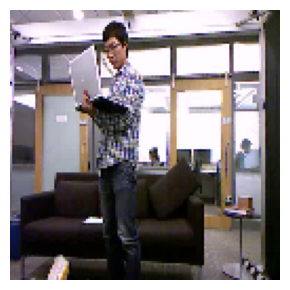

In [27]:
show_frame(videos[0,0])

In [ ]:
batch_size = 32
for i in range(0, len(video_generator), batch_size):
    batch_videos = [video_generator[j][0] for j in range(i, i+batch_size)]
    batch_labels = [video_generator[j][1] for j in range(i, i+batch_size)]

    augmented_videos = [noise_video(video) for video in batch_videos]
    
    print(np.array(augmented_videos, dtype=object).shape, np.array(batch_labels, dtype=object).shape)
    # video_generator.add(augmented_videos, batch_labels)

## ❌ DEPRECIATED Variables to store augmentation

In [ ]:
# augmented_features=[]
# augmented_labels=[]

## ❌ DEPRECIATED Apply `Noise` (augmentation)

In [ ]:
# # apply noise
# noise_videos, noise_labels = apply(noise_video, features, labels)

# noise_videos.shape, noise_labels.shape

In [ ]:
# augmented_features = noise_videos
# augmented_labels = noise_labels

# augmented_features.shape, augmented_labels.shape

In [ ]:
# del noise_videos, noise_labels

## ❌ DEPRECIATED Apply `Horizontal Flip`  (augmentation)

In [ ]:
# # apply horizontal flip
# flipped_videos, flipped_labels = apply(horizontal_flip, features, labels)

# flipped_videos.shape, flipped_labels.shape

In [ ]:
# augmented_features = np.concatenate((augmented_features, flipped_videos), axis=0)
# augmented_labels = np.concatenate((augmented_labels, flipped_labels), axis=0)

# augmented_features.shape, augmented_labels.shape

In [ ]:
# del flipped_videos, flipped_labels

## ❌ DEPRECIATED Apply `Random Shear`  (augmentation)

`Random Shear` is applied two times.
1. Shear Values of (0.9, -0.3)
2. Shear Values of (-0.9, 0.3)

In [ ]:
# # apply shear left
# sheared_videos, sheared_labels = apply(apply_shear_frames, features, labels, shear_right=0)

# sheared_videos.shape, sheared_labels.shape

In [ ]:
# augmented_features = np.concatenate((augmented_features, sheared_videos), axis=0)
# augmented_labels = np.concatenate((augmented_labels, sheared_labels), axis=0)

# augmented_features.shape, augmented_labels.shape

In [ ]:
# # apply shear right
# sheared_videos, sheared_labels = apply(apply_shear_frames, features, labels, shear_right=1)

# sheared_videos.shape, sheared_labels.shape

In [ ]:
# augmented_features = np.concatenate((augmented_features, sheared_videos), axis=0)
# augmented_labels = np.concatenate((augmented_labels, sheared_labels), axis=0)

# augmented_features.shape, augmented_labels.shape

In [ ]:
# del sheared_videos, sheared_labels

In [ ]:
# train_gen = VideoDataGenerator(train_video_frames, train_labels, batch_size=16, is_training=True)
# dataset = train_gen.as_dataset()
# for batch_frames, batch_labels in dataset.take(1):
#     print(batch_frames.shape, batch_labels.shape)

In [ ]:
# delele to free memory
#del features_train, labels_train, train_video_frames, train_labels, val_video_frames, val_labels, augmented_features, augmented_labels

In [ ]:
# Clear previous session to free memory
tf.keras.backend.clear_session()

# 🧪 Test Augmentation (Output)
## 🖼️ Horizontal Flip Output

In [ ]:
# flipped_video_1 = horizontal_flip(features[0])

# flipped_video_1=np.asarray(flipped_video_1)

# show_frame(flipped_video_1[0])
# flipped_video_1.shape

## 🖼️ Salt and Pepper Noise Output

In [ ]:
# noised_video = noise_video(features[0])

# print(noised_video.shape)
# show_frame(noised_video[0])

## 🖼️ Random Shear Output

In [ ]:
# print(features.shape)

# sheared_1 = apply_shear_frames(features[0], shear_right=0)
# sheared_2 = apply_shear_frames(features[0], shear_right=1)

# sheared_1 = np.asarray(sheared_1)
# sheared_2 = np.asarray(sheared_2)

# print(sheared_1.shape)
# show_frame(sheared_1[0])
# show_frame(sheared_2[0])

# 📌 Preparing Data for Training

## ❌ DEPCRECIATED Combine ***Original Videos*** with ***Augmented Videos***

In [ ]:
# # add augmented data together
# features = np.concatenate((features, augmented_features), axis=0)
# labels = np.concatenate((augmented_labels, labels), axis=0)

# features.shape, labels.shape

## Splitting data for ***Trainig*** and ***Testing***

In [ ]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(videos,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

## Splitting data for ***Training Set*** and ***Validation Set***

In [ ]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, train_labels.shape, val_video_frames.shape, val_labels.shape

In [ ]:
train_video_frames.shape, train_labels.shape

## Use Generator `Video Data Generator`

In [ ]:
# Create the training and validation generators
train_gen = VideoDataGenerator(
    videos=train_video_frames, 
    labels=train_labels, 
    batch_size=BATCH_SIZE,
    is_training=True
)

val_gen = VideoDataGenerator(
    videos=val_video_frames, 
    labels=val_labels, 
    batch_size=BATCH_SIZE,
    is_training=True
)

len(train_gen), len(val_gen)

## Inspect ***Generator*** Data on Epochs

In [ ]:
features, labels = train_gen[1]

print(train_gen.indices)

train_gen.on_epoch_end()

print(train_gen.indices)

BATCH_SIZE, features.shape, labels.shape

In [ ]:
# print(labels[5])
# show_frame(features[5,0])

In [ ]:
# # add augmented frames here
# train_video_frames = np.concatenate((train_video_frames, augmented_features), axis=0)
# train_labels = np.concatenate((train_labels, one_hot_encoded_augmented_labels), axis=0)

# def shuffle_data_and_labels(X, y):
#     indices = np.arange(len(X))
#     np.random.shuffle(indices)
#     return X[indices], y[indices]

# train_video_frames, train_labels = shuffle_data_and_labels(train_video_frames, train_labels)



# train_video_frames.shape, train_labels.shape

# ✨ Model Execution
## Creating Model

In [ ]:
# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

## Plot Model Structure

In [ ]:
# Plot the structure of the contructed model.
from tensorflow.keras.utils import plot_model

plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

## Model Compile

In [ ]:
# Create an Instance of Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ["accuracy"])


## 💪 Model Fit

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)



print(f"Dataset - {DATASET_NAME}")
print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS} videos/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

print("\n")

print(f"Training started for {len(train_video_frames)} videos of {NO_OF_CLASSES} classes with {len(val_video_frames)} videos for validation...")

xlstm_model.fit(
    train_gen.as_dataset(),
    validation_data=val_gen.as_dataset(),
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, lr_scheduler]
)

# Evaluation

## ⚡ Model Evaluate

In [ ]:
# previous code
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

## 📈 Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create test generator with batch_size matching test set size
test_gen = VideoDataGenerator(
    video_frames=features_test,
    labels=labels_test,
    batch_size=4,  # Process all test samples at once
)

# Get predictions
predictions = xlstm_model.predict(test_gen.as_dataset())
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

# Verify shapes
print(f"True classes shape: {true_classes.shape}")
print(f"Predicted classes shape: {predicted_classes.shape}")
assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST[-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()